In [1]:
import pandas as pd
import numpy as np
import sys, os

import matplotlib.pyplot as plt
from sklearn import datasets
import scipy
from matplotlib.colors import ListedColormap
from functools import partial

In [2]:
np.random.seed(5)               # Set the random seed.

In [3]:
datasets = {0:'tic_tac',1:'adult',2:'cloud',3:'my_dota',4:'uci_data'}
# choses via random dieroll
random_seeds = [3,6,1,5,2,2,1,5,2,6]

In [4]:
cloud_data = pd.read_pickle("./data/cloud_data_sample.pkl")  

In [136]:
cloud_data = cloud_data.sample(n=500, random_state=22)
cloud_data.head()

,kWh,Year,Month,Day,Hour,Minute,Relative Humidity,Dew Point,Surface Albedo,Precipitable Water,...,DNI,Wind Speed,Temperature,Solar Zenith Angle,Clearsky GHI,Clearsky DNI,Clearsky DHI,lat,lang,binary_class
data_id,,,,,,,,,,,,,,,,,,,,,
PGE-CSI-00021_2012-05-09 11:30:00,6.57675,2012,5,10,11,30,23.69,5,0.180,0.974,...,930,2.3,29,20.18,1009,930,136,37.112201,-120.286426,1
PGE-CSI-08397_2014-04-25 17:30:00,0.05775,2014,4,25,17,30,89.14,7,0.128,1.628,...,483,3.1,10,74.72,206,483,79,37.676485,-122.084338,1
PGE-CSI-07211_2014-02-14 06:00:00,0.00000,2014,2,14,6,0,100.00,9,0.099,1.524,...,0,1.5,9,102.41,0,0,0,37.870839,-122.272864,-1
A-1637_2014-05-12 00:00:00,0.00000,2014,5,12,0,0,58.14,5,0.170,1.034,...,0,1.2,14,123.27,0,0,0,38.552701,-121.722243,1
PGE-CSI-01965_2014-03-19 22:30:00,0.00100,2014,3,19,22,30,79.61,8,0.127,1.097,...,0,1.2,12,135.02,0,0,0,37.779026,-122.419906,-1


In [135]:
uci_dota = pd.read_pickle("./data/uci_dota_sample.pkl")  
uci_dota = uci_dota.sample(n=500, random_state=22)
uci_dota.head()

,team_won,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,game_mode_3,game_mode_4,game_mode_5,game_mode_6,game_mode_7,game_mode_8,game_mode_9,game_type_1,game_type_2,game_type_3
12632,-1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
37259,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
47652,-1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
70390,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
9144,-1,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,1


In [134]:
my_dota = pd.read_pickle("./data/my_dota.pkl")  
my_dota = my_dota.sample(n=500, random_state=22)
my_dota.head()

,team_won,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,game_mode_2,game_mode_3,game_mode_4,game_mode_5,game_mode_18,game_mode_22,game_mode_23,game_type_0,game_type_1,game_type_7
1176,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
12350,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
9858,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4387,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
12795,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [133]:
adult_data = pd.read_csv("./data/adult_data.csv")    
adult_data['class'] = adult_data['class'].where(adult_data['class'] == adult_data['class'][0], 1)
adult_data['class'] = adult_data['class'].where(adult_data['class'] == 1, -1)
adult_data= adult_data.sample(n=500, random_state=22)
adult_data.head()

,Unnamed: 0,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,class,workclass_ ?,workclass_ Federal-gov,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
35057,18776,44,225263,10,0,1408,46,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7449,7449,37,101020,13,4787,0,55,1,0,0,...,0,0,0,0,0,0,0,1,0,0
22289,6008,51,114927,11,7298,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
11354,11354,41,139160,13,0,0,40,-1,0,0,...,0,0,0,0,0,0,0,1,0,0
30394,14113,36,181589,13,0,0,32,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
tic_tac_data = pd.read_pickle("./data/tic_tac_data.pkl")  
tic_tac_data.head()

,x_won,t_l_b,t_l_o,t_l_x,t_m_b,t_m_o,t_m_x,t_r_b,t_r_o,t_r_x,...,m_r_x,b_l_b,b_l_o,b_l_x,b_m_b,b_m_o,b_m_x,b_r_b,b_r_o,b_r_x
0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,0
2,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0


In [10]:
X = []
X.append(cloud_data.drop(columns='binary_class'))
X.append(tic_tac_data.drop(columns='x_won'))
X.append(adult_data.drop(columns='class'))
X.append(uci_dota.drop(columns='team_won'))
X.append(my_dota.drop(columns='team_won'))


In [11]:
Y = []
Y.append(cloud_data['binary_class'].values.reshape(-1,1).astype(np.float))
Y.append(tic_tac_data['x_won'].values.reshape(-1,1).astype(np.float))
Y.append(adult_data['class'].values.reshape(-1,1).astype(np.float))
Y.append(uci_dota['team_won'].values.reshape(-1,1).astype(np.float))
Y.append(my_dota['team_won'].values.reshape(-1,1).astype(np.float))


In [12]:
def get_random_train_test(prop_test):
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    
    for i in datasets.keys():
       # print()
        X_and_Y = np.hstack((X[i], Y[i]))     # Stack them together for shuffling.
        np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

        #print(datasets[i])
       # print('X', X[i].shape)
       # print('Y', Y[i].shape)
        
        X_shuffled = X_and_Y[:,:-1]
        Y_shuffled = X_and_Y[:,-1]
        
        pivot = int(X[i].shape[0]*(1-prop_test))
        X_train.append(X_shuffled[:pivot]) 
        Y_train.append(Y_shuffled[:pivot])             
        X_test.append(X_shuffled[pivot:]) 
        Y_test.append(Y_shuffled[pivot:])
        
       # print('X_train', X_train[i].shape)
       # print('Y_train', Y_train[i].shape)
        
       # print('X_test', X_test[i].shape)
       # print('Y_test', Y_test[i].shape)
        
    return X_train, Y_train, X_test, Y_test

    

In [138]:
import math
import seaborn as sns       
import numbers
import copy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


cv_num = 3

In [14]:
def plot_grid_search_validation_curve(grid, param_to_vary,
                                      title='Validation Curve', ylim=None,
                                      xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    plt.legend(loc='lower right')

    plt.show()

In [15]:


# Calculate error given feature vectors X and labels Y.
def calc_error(Y_pred, Y):
    return np.array(y_predicted !=  Y_test[0]).astype(np.float32).mean()

In [16]:
#KNN model
pipe_knn = Pipeline([
    ('sc', StandardScaler()),     
    ('knn', KNeighborsClassifier()) 
])
k_max = 10

def get_knn_parm(n):
    step = math.log((n / cv_num) * (cv_num-1) ,k_max)
    return {'knn__n_neighbors': np.power(np.arange(1,k_max), step).astype(int), 'knn__p' : [1, 2,3]}


In [17]:
# SVM model
pipe_svm = Pipeline([
    ('sc', StandardScaler()),     
    ('svm', SVC()) 
])

def get_svm_parm(n):
    return {'svm__C': [10**c for c in np.arange(-7,3, dtype=float)], 'svm__kernel' : ['linear','rbf']}

In [28]:
# Random forest model
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier()) 
])

# used https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
# to get reasonble RF hyperparmeters then changed it to match http://lowrank.net/nikos/pubs/empirical.pdf
def get_rv_parm(n):
    s = int(n**0.5)
    n_estimators = [2**c for c in np.arange(7,13, dtype=int)]
    max_features = ['auto', 'sqrt']
    min_samples_split = [int(2**c * s) for c in np.arange(-1,4, dtype=float)]
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'rf__n_estimators': n_estimators,
                   'rf__max_features': max_features,
                   'rf__min_samples_split': min_samples_split,
                   'rf__bootstrap': bootstrap}
    return random_grid

In [29]:
classifiers = {'KNN' : 
                    {'pipe' : pipe_knn, 'params' : get_knn_parm, 'grid_list':[],'test_auc':[],'train_auc':[],'val_auc':[]},
                'SVM' : 
                   {'pipe' : pipe_svm, 'params' : get_svm_parm, 'grid_list':[],'test_auc':[],'train_auc':[],'val_auc':[]},
               'RF' :
                    {'pipe' : pipe_rf, 'params' : get_rv_parm, 'grid_list':[],'test_auc':[],'train_auc':[],'val_auc':[]}
              }
            


In [339]:
def train(x,y, model):
    clf = RandomizedSearchCV(estimator=model['pipe'],n_iter = 15,           
                  param_distributions=model['params'](x.shape[0]), 
                  cv=cv_num,
                  return_train_score=True,n_jobs=5, pre_dispatch = '2*n_jobs',  refit=True,scoring = 'auc')

    return clf.fit(x, y)

In [31]:
def test(x_test,y_test, model):
    y_pred  = model.predict(x_test)
    return accuracy_score(y_pred,y_test)
    

In [32]:
dict = copy.deepcopy(dict)

In [33]:
partions = [0.2,0.5,0.8]

In [34]:
def new_results_dic(partions, datasets, classifiers):
    results_dic = {}
    for i, part in enumerate(partions, start=0):
        results_dic[i] = {'partion' : part, 'datasets':{}}
        for dataset in datasets.items():
            results_dic[i]['datasets'][dataset[1]] = {'index' : dataset[0], 'classifiers':copy.deepcopy(classifiers)}
    return results_dic
        
    

In [35]:
def update_avrg_auc_over_n_trials(n, results_dic):
    
    for i in range(0,n):
        print('\ttrial', i)
        X_train, Y_train, X_test, Y_test = get_random_train_test(results_dic['partion'])
        for dataset in results_dic['datasets']:
            print('\t\tdataset', dataset)
            dataset = results_dic['datasets'][dataset]
            for classifier in dataset['classifiers']:
               # print('\t\t\ttunning ', classifier)
                classifier = dataset['classifiers'][classifier]
                grid = train(X_train[dataset['index']],Y_train[dataset['index']], classifier)
                classifier['test_auc'].append(test(X_test[dataset['index']], Y_test[dataset['index']],grid))
                classifier['train_auc'].append(grid.cv_results_['mean_train_score'][grid.best_index_])
                classifier['val_auc'].append(grid.cv_results_['mean_test_score'][grid.best_index_])

                classifier['grid_list'].append(grid)
    
        

In [36]:
def run_core_loop():
    results_dic = new_results_dic(partions, datasets, classifiers)
    for part in results_dic.values():
        print('partion', part['partion'])
        update_avrg_auc_over_n_trials(3, part)
    return results_dic
        

In [37]:
results_dic = run_core_loop()

partion 0.2
	trial 0
		dataset tic_tac
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset adult
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset cloud
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset my_dota
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset uci_data
			tunning  KNN
			tunning  SVM
			tunning  RF
	trial 1
		dataset tic_tac
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset adult
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset cloud
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset my_dota
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset uci_data
			tunning  KNN
			tunning  SVM
			tunning  RF
	trial 2
		dataset tic_tac
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset adult
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset cloud
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset my_dota
			tunning  KNN
			tunning  SVM
			tunning  RF
		dataset uci_data
			tunning  KNN
			tunning  SVM
			tunning

In [358]:
def get_part_str(part):
    return ' ' + str(int(round((100*(1-part['partion']))))) + '/' +str(int(round((100*part['partion'])))) + ' '

In [359]:
classifiers.keys()

dict_keys(['KNN', 'SVM', 'RF'])

In [360]:
columns = [ classifier + get_part_str(part) + auc + ' ' + end for classifier in classifiers.keys() 
           for part in results_dic.values() for auc in ['test','train','val'] for end in ['auc', 'std', 'text']]
avreges_names = ([classifier+ ' mean ' + auc for classifier in classifiers.keys() for auc in ['auc']])
columns += avreges_names


In [361]:
from statistics import mean 
from statistics import stdev as std 


In [362]:
final_summery = pd.DataFrame(columns=columns, index=results_dic[0]['datasets'].keys())


In [363]:
for part in results_dic.values():
    for dataset in part['datasets']:
        row = final_summery.loc[dataset]
        dataset = part['datasets'][dataset]
        for classifier in dataset['classifiers']:
            columns_head = classifier + get_part_str(part)
            classifier = dataset['classifiers'][classifier]
            for auc in ['test','train','val']:
                values = classifier[auc+'_auc'] 
                
                row[columns_head + auc + ' auc'] = round(mean(values)* 100, ndigits=1)
                row[columns_head + auc + ' std'] = round(std(values)* 100, ndigits=1)
                row[columns_head + auc + ' text'] = str( round(mean(values)* 100, ndigits=1)) + ' +- ' + str(round(std(values)* 100, ndigits=1)) + '%'

            
        for name in avreges_names:
            values = row.filter(regex='^'+name.split()[0]+'.*.*test.*' + name.split()[2])
            row[name] = round(values.mean(), ndigits=1)



In [364]:
final_summery[[c for c in columns if 'text' not in c]] = final_summery[[c for c in columns if 'text' not in c]].apply(pd.to_numeric)

In [365]:
final_summery[[c for c in columns if 'test text' in c or 'mean' in c]]

,KNN 80/20 test text,KNN 50/50 test text,KNN 20/80 test text,SVM 80/20 test text,SVM 50/50 test text,SVM 20/80 test text,RF 80/20 test text,RF 50/50 test text,RF 20/80 test text,KNN mean auc,SVM mean auc,RF mean auc
tic_tac,74.0 +- 2.4%,80.9 +- 1.9%,72.6 +- 2.1%,97.6 +- 1.1%,98.3 +- 0.2%,97.7 +- 1.1%,97.7 +- 2.1%,95.1 +- 1.0%,82.4 +- 2.5%,75.8,97.9,91.7
adult,74.3 +- 4.0%,76.4 +- 1.2%,73.7 +- 3.1%,73.0 +- 2.6%,74.0 +- 2.0%,76.0 +- 0.6%,72.3 +- 2.5%,76.3 +- 1.6%,75.4 +- 1.0%,74.8,74.3,74.7
cloud,73.0 +- 1.7%,75.2 +- 1.8%,73.5 +- 3.8%,79.3 +- 1.2%,81.5 +- 1.8%,78.4 +- 0.8%,76.7 +- 3.1%,80.4 +- 2.4%,75.3 +- 4.5%,73.9,79.7,77.5
my_dota,50.7 +- 3.5%,52.0 +- 2.4%,50.1 +- 1.4%,57.7 +- 3.2%,55.1 +- 3.2%,49.1 +- 0.7%,55.0 +- 6.1%,53.2 +- 0.0%,49.4 +- 1.0%,50.9,54.0,52.5
uci_data,52.3 +- 2.3%,49.7 +- 0.5%,50.2 +- 2.2%,51.7 +- 2.5%,47.5 +- 3.7%,49.0 +- 1.1%,54.3 +- 5.5%,50.0 +- 4.0%,47.5 +- 2.4%,50.7,49.4,50.6


In [366]:
final_summery['80/20 best'] = [name.split()[0] for name in final_summery[[c for c in columns if '80/20 test auc' in c]].idxmax(axis=1)]
final_summery['50/50 best'] = [name.split()[0] for name in final_summery[[c for c in columns if '50/50 test auc' in c]].idxmax(axis=1)]
final_summery['20/80 best'] = [name.split()[0] for name in final_summery[[c for c in columns if '20/80 test auc' in c]].idxmax(axis=1)]
final_summery['mean  best'] = [name.split()[0] for name in final_summery[[c for c in columns if 'mean auc' in c]].idxmax(axis=1)]

In [367]:
#plot_grid_search_validation_curve(grid, 'knn__p', log=False, ylim=(.4, 1.02))
#plot_grid_search_validation_curve(grid, 'knn__n_neighbors', log=True, ylim=(.4, 1.02))
#parm = classifiers['KNN']['params'](X_train[0].shape[0])
#scores = grid.cv_results_['mean_test_score'].reshape(len(parm['knn__n_neighbors']),len(parm['knn__p']))
#ax = sns.heatmap(scores

In [368]:
79.3+81.5+78.4

239.20000000000002

In [369]:
76.7+80.4+75.3

232.40000000000003

In [370]:
final_summery.loc['cloud'][[c for c in columns if 'test auc' in c]]

KNN 80/20 test auc      73
KNN 50/50 test auc    75.2
KNN 20/80 test auc    73.5
SVM 80/20 test auc    79.3
SVM 50/50 test auc    81.5
SVM 20/80 test auc    78.4
RF 80/20 test auc     76.7
RF 50/50 test auc     80.4
RF 20/80 test auc     75.3
Name: cloud, dtype: object

In [371]:
final_summery.filter(regex='.*best')

,80/20 best,50/50 best,20/80 best,mean best
tic_tac,RF,SVM,SVM,SVM
adult,KNN,KNN,SVM,KNN
cloud,SVM,SVM,SVM,SVM
my_dota,SVM,SVM,KNN,SVM
uci_data,RF,RF,KNN,KNN


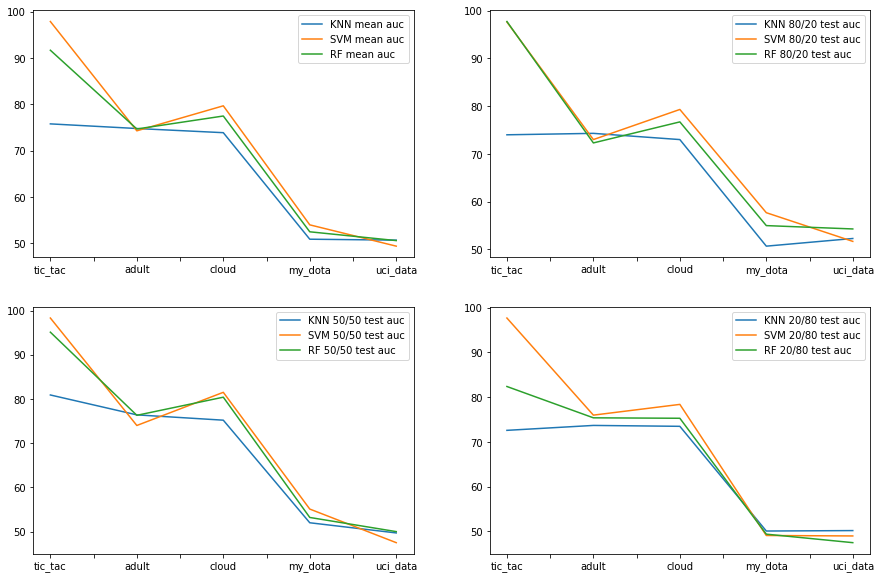

In [372]:
fig,axes =  plt.subplots(nrows=2, ncols=2,figsize=(15,10))
final_summery[[c for c in columns if 'mean auc' in c]].plot(subplots=False,ax=axes[0,0])
final_summery[[c for c in columns if '80/20 test auc' in c]].plot(subplots=False,ax=axes[0,1])
final_summery[[c for c in columns if '50/50 test auc' in c]].plot(subplots=False,ax=axes[1,0])
final_summery[[c for c in columns if '20/80 test auc' in c]].plot(subplots=False,ax=axes[1,1])
plt.show()


In [375]:
3*3*3

27

In [376]:
5*3*3

45

In [373]:
final_summery.filter(regex='.*text').transpose()

,tic_tac,adult,cloud,my_dota,uci_data
KNN 80/20 test text,74.0 +- 2.4%,74.3 +- 4.0%,73.0 +- 1.7%,50.7 +- 3.5%,52.3 +- 2.3%
KNN 80/20 train text,86.9 +- 0.3%,75.5 +- 1.0%,78.5 +- 0.8%,76.3 +- 20.8%,85.5 +- 25.1%
KNN 80/20 val text,79.6 +- 1.0%,75.5 +- 1.0%,77.3 +- 1.0%,55.5 +- 0.7%,54.4 +- 1.4%
KNN 50/50 test text,80.9 +- 1.9%,76.4 +- 1.2%,75.2 +- 1.8%,52.0 +- 2.4%,49.7 +- 0.5%
KNN 50/50 train text,89.8 +- 2.0%,74.1 +- 2.1%,78.7 +- 0.4%,100.0 +- 0.0%,61.1 +- 5.4%
KNN 50/50 val text,82.9 +- 4.2%,74.3 +- 2.4%,73.7 +- 3.0%,55.9 +- 0.9%,55.3 +- 1.3%
KNN 20/80 test text,72.6 +- 2.1%,73.7 +- 3.1%,73.5 +- 3.8%,50.1 +- 1.4%,50.2 +- 2.2%
KNN 20/80 train text,86.4 +- 11.9%,77.4 +- 10.4%,77.3 +- 3.9%,68.0 +- 12.5%,72.2 +- 24.1%
KNN 20/80 val text,74.7 +- 2.7%,73.4 +- 3.8%,70.4 +- 2.1%,58.6 +- 3.5%,59.9 +- 1.5%
SVM 80/20 test text,97.6 +- 1.1%,73.0 +- 2.6%,79.3 +- 1.2%,57.7 +- 3.2%,51.7 +- 2.5%


In [374]:
3*3*

SyntaxError: invalid syntax (<ipython-input-374-6010fb0a2822>, line 1)